# 2 - Genotyping quality control and Principal Component Analysis (PCA) computation

In [55]:
from matplotlib_venn import venn3
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import subprocess
import math
import sys
import os

## Introduction

In this step of the preprocessing we perform a quality control on genotyping data. The quality control is made to clean our genotyping data from potential errors and noise that cluld have been introduced during genotype calling.

During this phase we filter genotyping data for:
- sex discrepancies
- SNPs with A/T and C/G
- SNP missingness rate
- genotyping missingness rate
- minor allele frequency (MAF)
- deviations from Hardy-weinberg equilibrium (HWE)

After the QC step, we compute the PCA for genotyping data and plot the resulting measures. We plot the PCA in order to explore how the subjects involved in the study cluster by their population of origin.

In [56]:
ppmi_merge_fn = "../../data/genotyping/PPMI_merge"
ppmi_merge_bim_fn = "../../data/genotyping/PPMI_merge.bim"

### Exploring the merged genotyping dataset

In [57]:
ppmi_merge_bim = pd.read_csv(ppmi_merge_bim_fn, sep="\t", header=None)
ppmi_merge_bim.head(n=10)

,0,1,2,3,4,5
0,1,NeuroX_PARK7_Pro158del,0,0,0,I
1,1,NeuroX_PINK1_23bp_del_ex7,0,0,0,I
2,1,NeuroX_PINK1_534_535insQ,0,0,0,D
3,1,NeuroX_PINK1_Asp525fs,0,0,0,D
4,1,NeuroX_PINK1_Cys549fs,0,0,0,I
5,1,NeuroX_PINK1_Lys520fs,0,0,0,I
6,1,exm2268640,0,762320,T,C
7,1,exm41,0,861349,0,C
8,1,exm1916089,0,865545,0,0
9,1,exm44,0,865584,0,G


## Quality Control

### Subject-level QC

As first step of QC, we remove subjects where provided sex information does not match the genotype inferred sex. This could cause data quality issues

In [58]:
!plink --bfile {ppmi_merge_fn} --check-sex --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge
  --check-sex
  --out ../../data/genotyping/PPMI_merge

32768 MB RAM detected; reserving 16384 MB for main workspace.
457171 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../data/genotyping/PPMI_merge.hh ); many commands treat these as missing.
treat these as missing.
Total genotyping rate is 0.95703.
457171 variants and 520 people pass filt

In total 12 "problems" were detected. Let's retrieve those subjects and store their IIDs and FIDs in a file named ```remove_subjects.txt```.

In [59]:
remove_subjects = "../../data/genotyping/remove_subjects.txt"
checksex = pd.read_csv("".join([ppmi_merge_fn, ".sexcheck"]), sep="\s+")
checksex[checksex["STATUS"] == "PROBLEM"].iloc[:, [0,1]].to_csv(remove_subjects, header=False, index=False, sep=" ")

We can now remove the subjects for which a sex discrepancy was detected and those with 50% rate of genotype missingness

In [60]:
!plink --bfile {ppmi_merge_fn} --remove {remove_subjects} --mind 0.5 --make-bed --out {"_".join([ppmi_merge_fn, "subjQC"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge
  --make-bed
  --mind 0.5
  --out ../../data/genotyping/PPMI_merge_subjQC
  --remove ../../data/genotyping/remove_subjects.txt

32768 MB RAM detected; reserving 16384 MB for main workspace.
457171 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
--remove: 508 people remaining.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../da

### SNP-level QC

Now that our data are OK at subject-level, we can proceed with a SNP-level QC.

We start by searching and removing the A/T and C/G SNPs. 

In [61]:
bad1 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'A') & (ppmi_merge_bim.iloc[:,5] == 'T')]
bad2 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'T') & (ppmi_merge_bim.iloc[:,5] == 'A')]
bad3 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'C') & (ppmi_merge_bim.iloc[:,5] == 'G')]
bad4 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'G') & (ppmi_merge_bim.iloc[:,5] == 'C')]

badSnps = pd.concat([bad1, bad2, bad3, bad4])
badSnps_set = set(badSnps.iloc[:,1].values.tolist())

badsnps_fn = "../../data/genotyping/badsnps.txt"
pd.DataFrame(list(badSnps_set)).to_csv(badsnps_fn, header=False, index=False)

We have 34,510 A/T or C/G SNPs to remove. Parkinson's disease SNP biomarkers have been shown to reside on autosomal chromosomes. Thus, we also restrict our ananlysis to autosomal chromosomes.

In [62]:
ppmi_merge_fn = "_".join([ppmi_merge_fn, "subjQC"])

In [63]:
!plink --bfile {ppmi_merge_fn} --exclude {badsnps_fn} --make-bed --out {"_".join([ppmi_merge_fn, "snpQC"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC
  --exclude ../../data/genotyping/badsnps.txt
  --make-bed
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC

32768 MB RAM detected; reserving 16384 MB for main workspace.
457171 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
--exclude: 422661 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../data/genotyping/PPMI_merge_subjQC_snpQC.hh ); many co

Now we exclude only ChrX and ChrY - they require special handling (i.e., 
no signal on Y in women and all either 0 or 2 in X in men)

In [64]:
ppmi_merge_fn = "_".join([ppmi_merge_fn, "snpQC"])

In [65]:
!plink --bfile {ppmi_merge_fn} --not-chr 23,24 --make-bed --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --make-bed
  --not-chr 23,24
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC

32768 MB RAM detected; reserving 16384 MB for main workspace.
filenames.
414059 out of 422661 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.95535.
414059 variants and 508 people pass filters and QC.
Note: No

We can proceed by filtering the SNPs with a genotyping missingness rate of 10%.

In [66]:
!plink --bfile {ppmi_merge_fn} --geno 0.1 --make-bed --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --geno 0.1
  --make-bed
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC

32768 MB RAM detected; reserving 16384 MB for main workspace.
filenames.
414059 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.95535.
21023 variants removed due to missing genotype data (--geno).
393036 variants a

During the previous QC step were removed 20,896 SNPs with a genotyping missingness rate of 10%. 

Now, we filter SNP dataset by remove those SNPs with MAF < 5%.

In [67]:
!plink --bfile {ppmi_merge_fn} --maf 0.05 --make-bed --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --maf 0.05
  --make-bed
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC

32768 MB RAM detected; reserving 16384 MB for main workspace.
filenames.
393036 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997871.
263485 variants removed due to minor allele threshold(s)
(--maf/--max-maf/--ma

Now we remove those SNPs deviating from HWE.

In [68]:
!plink --bfile {ppmi_merge_fn} --hwe 1e-06 --make-bed --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --hwe 1e-06
  --make-bed
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC

32768 MB RAM detected; reserving 16384 MB for main workspace.
filenames.
129551 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996562.
--hwe: 310 variants removed due to Hardy-Weinberg exact test.
129241 variants

At the end we have 129,241 SNPs which passed all the QC steps

## Principal Component Analysis (PCA) computation

During this step we compute the first 20 Principal Components (PCs) of the relatedness matrix. This will help us to explore the structure of the population analyzed

In [69]:
!plink --bfile {ppmi_merge_fn} --pca 20 --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --pca 20

32768 MB RAM detected; reserving 16384 MB for main workspace.
129241 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
Using up to 11 threads (change this with --threads).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996618.
129241 variants and 508 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calcul

Let's explore the computed PCs.

In [71]:
ppmi_pca = pd.read_csv(".".join([ppmi_merge_fn, "eigenvec"]), sep=' ', header=None)

# assign FID and IID
cnames = ['FID','IID']
for i in range(1, 21):
    cnames.append("PC"+str(i))
    
ppmi_pca.columns = cnames
ppmi_pca.head(n=15)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,3000,3000,0.009620,-0.018383,-0.006077,0.002944,0.065530,-0.001195,-0.011427,-0.057525,...,-0.029895,0.001230,-0.012959,-0.044284,0.016792,-0.001202,0.046688,0.100742,-0.014716,0.043372
1,3001,3001,0.010583,-0.009584,0.016208,0.008378,-0.036768,0.041353,-0.045443,-0.010500,...,0.039714,-0.092736,-0.084541,-0.047412,-0.064102,0.057433,0.055092,0.007267,0.026552,0.012502
2,3002,3002,0.010396,0.081456,-0.026897,-0.015026,-0.002355,-0.024748,-0.003067,0.012301,...,-0.008700,0.000647,-0.026061,0.007198,0.009459,-0.059061,0.027866,0.054570,0.070527,0.030845
3,3004,3004,0.014894,-0.023619,0.014870,-0.019945,-0.011236,0.022277,0.006464,-0.115623,...,0.007810,-0.025057,0.018370,0.035520,0.056734,0.027940,0.022722,0.065273,0.131407,0.006572
4,3006,3006,0.014801,-0.009137,0.057517,0.080119,0.042512,0.007822,-0.036668,-0.036419,...,0.036321,-0.037696,0.003431,-0.025255,-0.019522,0.005962,-0.000599,0.058824,-0.068176,0.047920
5,3008,3008,0.006206,-0.013832,-0.009979,-0.061597,0.021045,0.052704,0.031556,0.031185,...,0.016810,-0.027895,0.033793,0.105406,0.008383,0.071430,-0.013646,-0.012456,-0.035288,0.051166
6,3009,3009,-0.269618,0.017906,0.024254,0.013916,0.014952,-0.027306,-0.049455,-0.035033,...,-0.025431,-0.027858,-0.038425,0.010762,0.009870,-0.009680,0.005274,-0.011396,0.039049,-0.018869
7,3011,3011,0.016504,0.037790,0.017749,0.000276,0.043453,-0.031467,0.000388,-0.016955,...,0.040156,-0.055912,0.042519,0.031508,-0.023589,0.029678,-0.020006,0.045144,-0.020639,-0.050254
8,3012,3012,-0.002068,0.010024,0.005440,0.012521,-0.009781,0.063799,0.060798,0.039360,...,-0.040630,0.038311,-0.003259,0.006856,0.031687,-0.005694,-0.020551,-0.054667,-0.016467,0.037571
9,3016,3016,0.009424,-0.032460,-0.008071,-0.068250,-0.014159,-0.025139,-0.009979,0.076501,...,0.032864,-0.025296,-0.048581,0.095362,-0.001087,0.020755,-0.021938,-0.018079,0.040692,-0.064751


Let's plot PC1 vs PC2

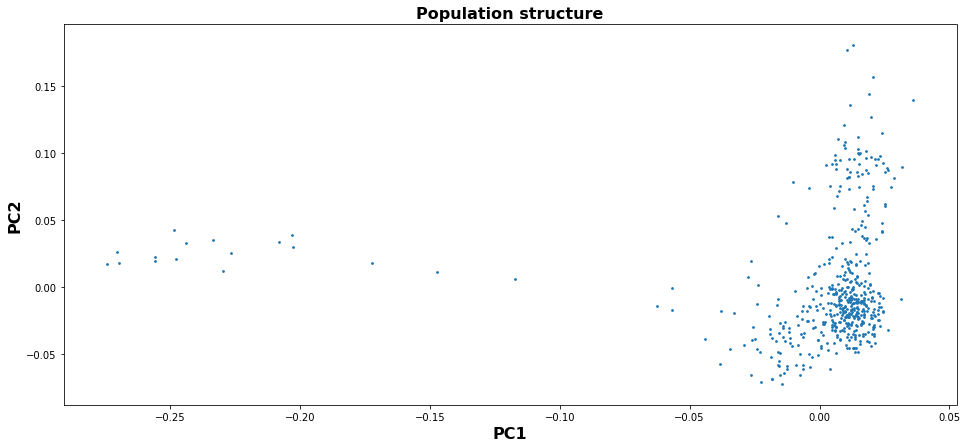

In [72]:
#make a scatter plot of PC1 vs PC2
plt.figure(figsize=(16, 7))
plt.scatter(ppmi_pca.PC1, ppmi_pca.PC2.values, s=3)
plt.title('Population structure', fontweight="bold", fontsize=16)
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)
plt.show()

and PC2 vs PC3

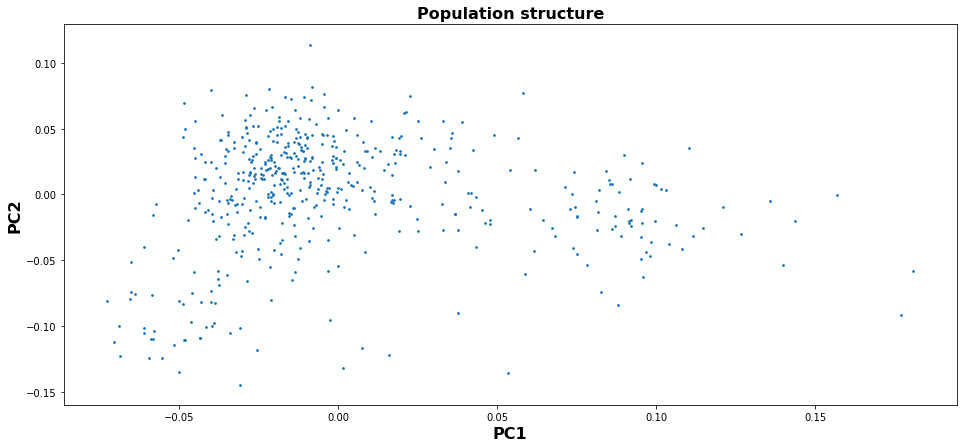

In [73]:
#make a scatter plot of PC1 vs PC2
plt.figure(figsize=(16, 7))
plt.scatter(ppmi_pca.PC2, ppmi_pca.PC3.values, s=3)
plt.title('Population structure', fontweight="bold", fontsize=16)
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)
plt.show()

Now let's color dots by population of origin. 

The original population information is available in the Demographics file. So, we load the corresponding file and merge the Demographics file with the DataFrame containing PC values.

In [74]:
demo_fn = "../../data/patient_docs/Screening___Demographics.csv"
demo = pd.read_csv(demo_fn)
demo.head()

,REC_ID,F_STATUS,PATNO,EVENT_ID,PAG_NAME,SIGNCNST,CONSNTDT,APPRDX,CURRENT_APPRDX,P3GRP,...,PRJENRDT,REFERRAL,DECLINED,RSNDEC,EXCLUDED,RSNEXC,ORIG_ENTRY,LAST_UPDATE,QUERY,SITE_APRV
0,224392801,V,3400,CONSENT,SCREEN,1.0,06/2010,1.0,1.0,NaN,...,07/2010,60.0,NaN,NaN,NaN,NaN,06/2010,2010-12-17 13:58:57.0,NaN,07/2010
1,224394301,V,3401,CONSENT,SCREEN,1.0,06/2010,2.0,2.0,NaN,...,07/2010,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 11:09:56.0,NaN,07/2010
2,224398401,V,3402,CONSENT,SCREEN,1.0,06/2010,3.0,3.0,NaN,...,10/2011,1.0,NaN,NaN,NaN,NaN,06/2010,2011-09-27 15:12:25.0,NaN,07/2010
3,224400201,V,3403,CONSENT,SCREEN,1.0,06/2010,1.0,1.0,NaN,...,07/2010,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 11:35:45.0,NaN,07/2010
4,224718101,V,3404,CONSENT,SCREEN,1.0,06/2010,2.0,2.0,NaN,...,07/2010,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 12:00:48.0,NaN,07/2010


For each patient we have a binary vector to identify the population(s) from which he/she come from.

We create a new column on the DataFrame discretizing the popultaion of origin.

In [76]:
pop_info = demo.iloc[:,12:19]
pop_info["PATNO"] = demo.iloc[:,2].tolist()
pops = list()
popDict = {0:"Hispanic/Latino", 1:"Indian/Alaska", 2:"Asian", 3:"Black/African American", 4:"Hawaiian/Other Pacif",
           5:"White", 6:"Race not specified"}
try:
    for i in range(len(pop_info.index)):
        patPop = pop_info.iloc[i,:7].tolist()
        if(sum(patPop) > 1):
            pops.append("More than one race")
        elif(sum(patPop) == 0 or np.all(np.isnan(patPop))):
            pops.append("Race not specified")
        else:
            j = np.where(np.array(patPop) == 1)
            pops.append(popDict[int(j[0])])
            
except Exception as e:
    raise e
    
demo["POPULATION"] = pops
demo.head()

,REC_ID,F_STATUS,PATNO,EVENT_ID,PAG_NAME,SIGNCNST,CONSNTDT,APPRDX,CURRENT_APPRDX,P3GRP,...,REFERRAL,DECLINED,RSNDEC,EXCLUDED,RSNEXC,ORIG_ENTRY,LAST_UPDATE,QUERY,SITE_APRV,POPULATION
0,224392801,V,3400,CONSENT,SCREEN,1.0,06/2010,1.0,1.0,NaN,...,60.0,NaN,NaN,NaN,NaN,06/2010,2010-12-17 13:58:57.0,NaN,07/2010,White
1,224394301,V,3401,CONSENT,SCREEN,1.0,06/2010,2.0,2.0,NaN,...,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 11:09:56.0,NaN,07/2010,White
2,224398401,V,3402,CONSENT,SCREEN,1.0,06/2010,3.0,3.0,NaN,...,1.0,NaN,NaN,NaN,NaN,06/2010,2011-09-27 15:12:25.0,NaN,07/2010,White
3,224400201,V,3403,CONSENT,SCREEN,1.0,06/2010,1.0,1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 11:35:45.0,NaN,07/2010,White
4,224718101,V,3404,CONSENT,SCREEN,1.0,06/2010,2.0,2.0,NaN,...,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 12:00:48.0,NaN,07/2010,White


In [77]:
# merge demographics with PCs
ppmi_pca = ppmi_pca.merge(demo, left_on=['IID'], right_on=['PATNO'])
ppmi_pca.head(n=10)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,REFERRAL,DECLINED,RSNDEC,EXCLUDED,RSNEXC,ORIG_ENTRY,LAST_UPDATE,QUERY,SITE_APRV,POPULATION
0,3000,3000,0.009620,-0.018383,-0.006077,0.002944,0.065530,-0.001195,-0.011427,-0.057525,...,31.0,NaN,NaN,NaN,NaN,01/2011,2011-01-19 15:44:58.0,NaN,01/2011,White
1,3001,3001,0.010583,-0.009584,0.016208,0.008378,-0.036768,0.041353,-0.045443,-0.010500,...,60.0,NaN,NaN,NaN,NaN,02/2011,2011-02-10 13:43:30.0,NaN,03/2011,White
2,3002,3002,0.010396,0.081456,-0.026897,-0.015026,-0.002355,-0.024748,-0.003067,0.012301,...,1.0,NaN,NaN,NaN,NaN,03/2011,2020-04-01 17:33:42.0,NaN,03/2011,White
3,3004,3004,0.014894,-0.023619,0.014870,-0.019945,-0.011236,0.022277,0.006464,-0.115623,...,99.0,NaN,NaN,NaN,NaN,03/2011,2011-03-30 14:43:13.0,NaN,03/2011,White
4,3006,3006,0.014801,-0.009137,0.057517,0.080119,0.042512,0.007822,-0.036668,-0.036419,...,1.0,NaN,NaN,NaN,NaN,03/2011,2020-04-22 09:14:39.0,NaN,03/2011,White
5,3008,3008,0.006206,-0.013832,-0.009979,-0.061597,0.021045,0.052704,0.031556,0.031185,...,4.0,NaN,NaN,NaN,NaN,05/2011,2013-10-31 14:28:09.0,NaN,05/2011,White
6,3009,3009,-0.269618,0.017906,0.024254,0.013916,0.014952,-0.027306,-0.049455,-0.035033,...,4.0,NaN,NaN,NaN,NaN,05/2011,2011-05-31 13:01:14.0,NaN,05/2011,Black/African American
7,3011,3011,0.016504,0.037790,0.017749,0.000276,0.043453,-0.031467,0.000388,-0.016955,...,1.0,NaN,NaN,NaN,NaN,06/2011,2011-07-22 16:39:28.0,NaN,06/2011,White
8,3012,3012,-0.002068,0.010024,0.005440,0.012521,-0.009781,0.063799,0.060798,0.039360,...,1.0,NaN,NaN,NaN,NaN,10/2011,2011-10-12 13:48:43.0,NaN,10/2011,White
9,3016,3016,0.009424,-0.032460,-0.008071,-0.068250,-0.014159,-0.025139,-0.009979,0.076501,...,4.0,NaN,NaN,NaN,NaN,01/2012,2012-01-12 13:19:24.0,NaN,01/2012,White


We can now plot the population structure, by coloring the dots by population(s) of origin 

Text(0, 0.5, 'PC2')

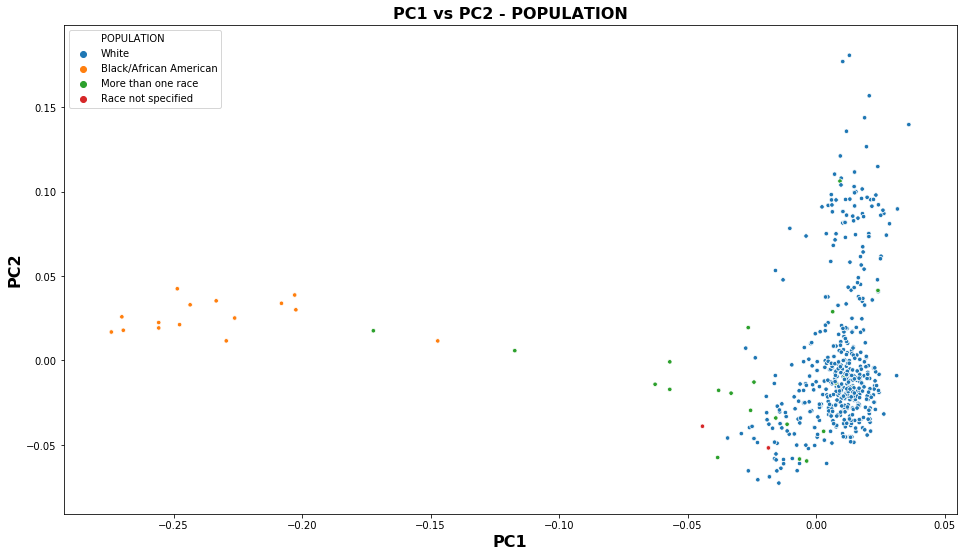

In [79]:
plt.figure(figsize=(16,9))
sns.scatterplot(x='PC1', y='PC2', hue='POPULATION', data=ppmi_pca, s=20)
plt.title('PC1 vs PC2 - POPULATION', fontsize=16, fontweight="bold")
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)

Text(0, 0.5, 'PC3')

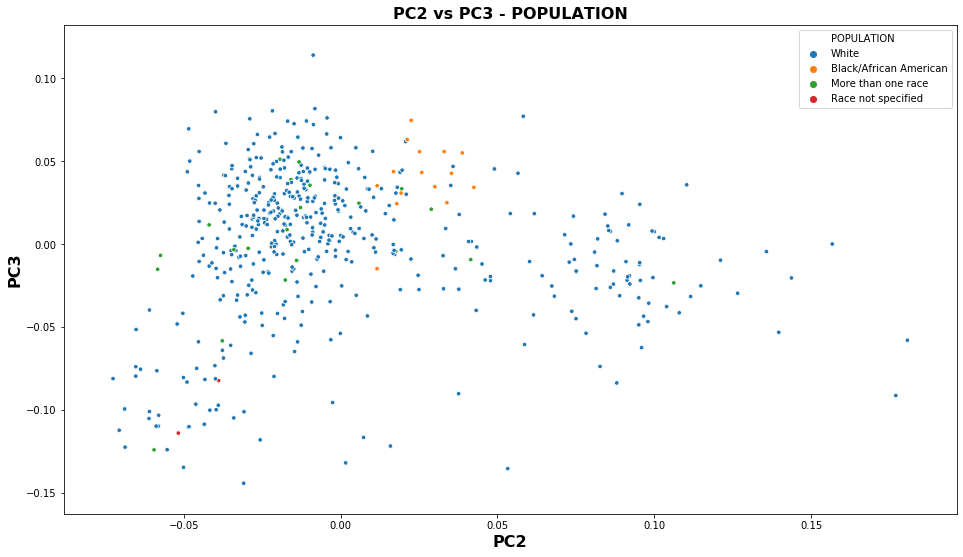

In [80]:
plt.figure(figsize=(16,9))
sns.scatterplot(x='PC2', y='PC3', hue='POPULATION', data=ppmi_pca, s=20)
plt.title('PC2 vs PC3 - POPULATION', fontsize=16, fontweight="bold")
plt.xlabel('PC2', fontweight="bold", fontsize=16)
plt.ylabel('PC3', fontweight="bold", fontsize=16)

To avoid possible bias during the SNP-phenotype associations computing the GWAS, we consider only those subjects with European ancestry.

In [81]:
eu_subjs = "../../data/genotyping/eu_subjs.txt"
ppmi_pca[ppmi_pca['POPULATION'] == "White"].iloc[:, 0:2].to_csv(eu_subjs, header=False, index=False, sep=" ")

We keep 469 subjects out of the original 508 individuals which passed QC steps.

Now, let's retrieve data regarding those 469 individuals with PLINK.

In [82]:
ppmi_eu_fn = "../../data/genotyping/PPMI_eu"
!plink --bfile {ppmi_merge_fn} --keep {eu_subjs} --make-bed --out {ppmi_eu_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_eu.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --keep ../../data/genotyping/eu_subjs.txt
  --make-bed
  --out ../../data/genotyping/PPMI_eu

32768 MB RAM detected; reserving 16384 MB for main workspace.
129241 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
--keep: 469 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 469 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.996655.
129241 variants and 469 people pass fil

Let's now explore the new population structure. As done before, to do this we compute the first 20 PCs. Then we plot PC1 vs PC2.

In [83]:
!plink --bfile {ppmi_eu_fn} --pca 20 --out {ppmi_eu_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_eu.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_eu
  --out ../../data/genotyping/PPMI_eu
  --pca 20

32768 MB RAM detected; reserving 16384 MB for main workspace.
129241 variants loaded from .bim file.
469 people (317 males, 152 females) loaded from .fam.
Using up to 11 threads (change this with --threads).
Before main variant filters, 469 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996655.
129241 variants and 469 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.
--pca: Results saved to ../../da

In [85]:
ppmi_eu_pca = pd.read_csv(".".join([ppmi_eu_fn, "eigenvec"]), header=None, sep=" ")

# assign FID and IID
cnames = ['FID','IID']
for i in range(1, 21):
    cnames.append("PC"+str(i))
    
ppmi_eu_pca.columns = cnames
ppmi_eu_pca.head(n=15)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,3000,3000,0.018987,-0.005074,0.011313,0.067230,-0.002608,-0.019518,0.045573,-0.027975,...,-0.024316,-0.042898,0.018516,0.015955,-0.067652,-0.030056,-0.122976,0.072538,0.021981,-0.056022
1,3001,3001,0.011662,0.015699,0.013885,-0.037461,0.044423,-0.040470,0.018049,-0.047628,...,0.070127,-0.087445,0.012496,-0.043454,-0.049653,0.033662,0.012825,0.067354,-0.035693,0.033370
2,3002,3002,-0.080818,-0.031182,-0.021825,0.001876,-0.025803,-0.001975,-0.007108,0.014425,...,0.021740,0.010909,0.005617,-0.021077,-0.009654,-0.092877,-0.002347,-0.012588,-0.096683,-0.032421
3,3004,3004,0.023103,0.020259,-0.017457,-0.007518,0.030301,0.004364,0.121658,-0.022347,...,-0.037424,0.019649,-0.004431,0.079575,0.008952,-0.080835,-0.050079,-0.022493,-0.043180,-0.083907
4,3006,3006,0.005761,0.059170,0.090503,0.026676,0.004160,-0.039380,0.027678,-0.007244,...,-0.017207,0.005676,-0.009592,-0.001916,-0.026075,0.019609,-0.037679,0.019912,-0.047320,-0.036032
5,3008,3008,0.014826,-0.010361,-0.064615,0.032082,0.048853,0.041178,-0.020457,0.019715,...,0.068211,0.093707,-0.059759,0.119228,0.023058,0.055126,0.032734,0.040393,0.002640,0.055079
6,3011,3011,-0.041758,0.021581,0.010637,0.034433,-0.030234,-0.001914,0.031075,0.011360,...,0.012250,0.054092,-0.013991,0.029746,0.006231,0.061570,-0.065781,-0.056160,0.004360,-0.024176
7,3012,3012,-0.003222,-0.008162,0.012637,-0.003085,0.064057,0.068744,-0.041053,0.009491,...,0.018159,-0.014822,-0.000119,0.007796,0.038686,0.005638,0.035571,0.052117,0.037662,0.025977
8,3016,3016,0.032761,-0.002351,-0.076185,-0.005419,-0.029480,-0.015726,-0.073960,-0.035091,...,0.092007,-0.016803,-0.074317,0.016707,0.067945,-0.005128,0.024264,-0.052657,-0.009345,0.029521
9,3018,3018,0.020577,0.001813,0.070613,-0.045929,-0.062746,0.042612,-0.006100,0.037924,...,-0.030523,-0.047768,0.083160,0.039343,0.045862,0.098620,0.053160,0.026677,-0.034415,-0.029755


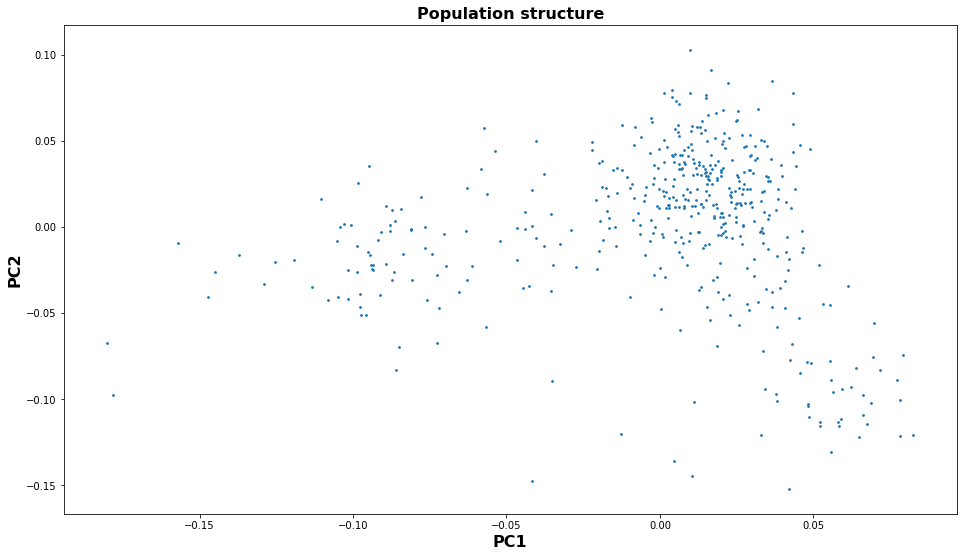

In [87]:
#make a scatter plot of PC1 vs PC2
plt.figure(figsize=(16, 9))
plt.scatter(ppmi_eu_pca.PC1, ppmi_eu_pca.PC2.values, s=3)
plt.title('Population structure', fontweight="bold", fontsize=16)
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)
plt.show()

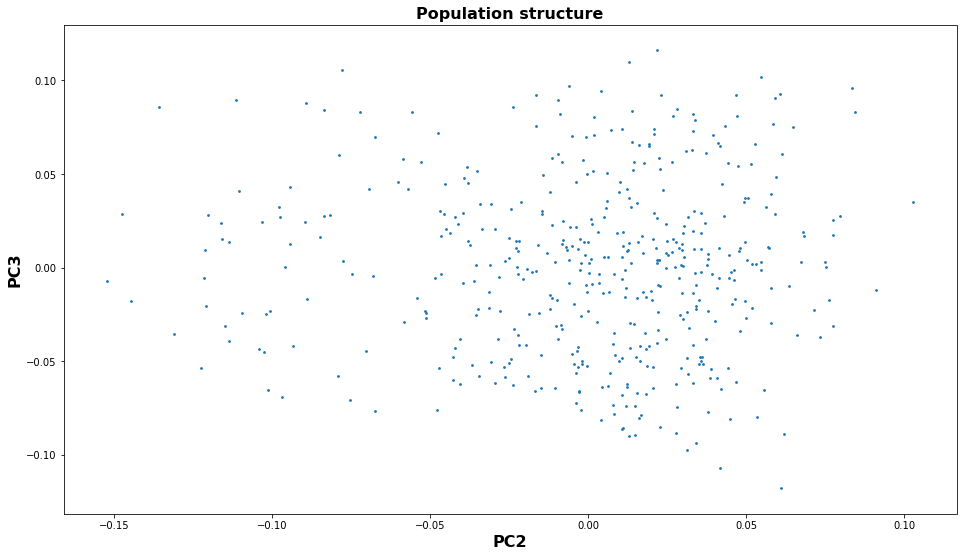

In [88]:
#and of PC2 vs PC3
plt.figure(figsize=(16, 9))
plt.scatter(ppmi_eu_pca.PC2, ppmi_eu_pca.PC3.values, s=3)
plt.title('Population structure', fontweight="bold", fontsize=16)
plt.xlabel('PC2', fontweight="bold", fontsize=16)
plt.ylabel('PC3', fontweight="bold", fontsize=16)
plt.show()

We can explore how the population is distributed with respect to their enrollment cathegory, i.e. wether they are Healthy controls (HCs), Parkinson's Disease patients (PD) or Subjects With Evidences of Dopamine Deficiency (SWEDD).

First, let's retrieve the enrollment cathegory information for the individuals with European ancestry from the patient status file.

In [89]:
status_fn = "../../data/patient_docs/Patient_Status.csv"
status = pd.read_csv(status_fn)
status = status[status["PATNO"].isin(ppmi_eu_pca.iloc[:, 1].tolist())].reset_index(drop=True)
status.head()

,PATNO,RECRUITMENT_CAT,IMAGING_CAT,ENROLL_DATE,ENROLL_CAT,ENROLL_STATUS,DESCRP_CAT,STATUS_DATE
0,3000,HC,HC,02/2011,HC,Enrolled,NaN,02/2011
1,3001,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
2,3002,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
3,3004,HC,HC,04/2011,HC,Enrolled,NaN,04/2011
4,3006,PD,PD,05/2011,PD,Withdrew,NaN,10/2013


And merge the PCs DataFrame with enrollment information.

In [90]:
ppmi_eu_pca = ppmi_eu_pca.merge(status, left_on=["IID"], right_on=["PATNO"])
ppmi_eu_pca.head(n=10)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC19,PC20,PATNO,RECRUITMENT_CAT,IMAGING_CAT,ENROLL_DATE,ENROLL_CAT,ENROLL_STATUS,DESCRP_CAT,STATUS_DATE
0,3000,3000,0.018987,-0.005074,0.011313,0.067230,-0.002608,-0.019518,0.045573,-0.027975,...,0.021981,-0.056022,3000,HC,HC,02/2011,HC,Enrolled,NaN,02/2011
1,3001,3001,0.011662,0.015699,0.013885,-0.037461,0.044423,-0.040470,0.018049,-0.047628,...,-0.035693,0.033370,3001,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
2,3002,3002,-0.080818,-0.031182,-0.021825,0.001876,-0.025803,-0.001975,-0.007108,0.014425,...,-0.096683,-0.032421,3002,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
3,3004,3004,0.023103,0.020259,-0.017457,-0.007518,0.030301,0.004364,0.121658,-0.022347,...,-0.043180,-0.083907,3004,HC,HC,04/2011,HC,Enrolled,NaN,04/2011
4,3006,3006,0.005761,0.059170,0.090503,0.026676,0.004160,-0.039380,0.027678,-0.007244,...,-0.047320,-0.036032,3006,PD,PD,05/2011,PD,Withdrew,NaN,10/2013
5,3008,3008,0.014826,-0.010361,-0.064615,0.032082,0.048853,0.041178,-0.020457,0.019715,...,0.002640,0.055079,3008,HC,HC,06/2011,HC,Enrolled,NaN,06/2011
6,3011,3011,-0.041758,0.021581,0.010637,0.034433,-0.030234,-0.001914,0.031075,0.011360,...,0.004360,-0.024176,3011,HC,HC,07/2011,HC,Withdrew,NaN,07/2014
7,3012,3012,-0.003222,-0.008162,0.012637,-0.003085,0.064057,0.068744,-0.041053,0.009491,...,0.037662,0.025977,3012,PD,PD,11/2011,PD,Enrolled,NaN,11/2011
8,3016,3016,0.032761,-0.002351,-0.076185,-0.005419,-0.029480,-0.015726,-0.073960,-0.035091,...,-0.009345,0.029521,3016,HC,HC,02/2012,HC,Enrolled,NaN,02/2012
9,3018,3018,0.020577,0.001813,0.070613,-0.045929,-0.062746,0.042612,-0.006100,0.037924,...,-0.034415,-0.029755,3018,PD,PD,04/2012,PD,Enrolled,NaN,04/2012


And plot the population structure, by coloring the dots by enrollment cathegory.

Text(0, 0.5, 'PC2')

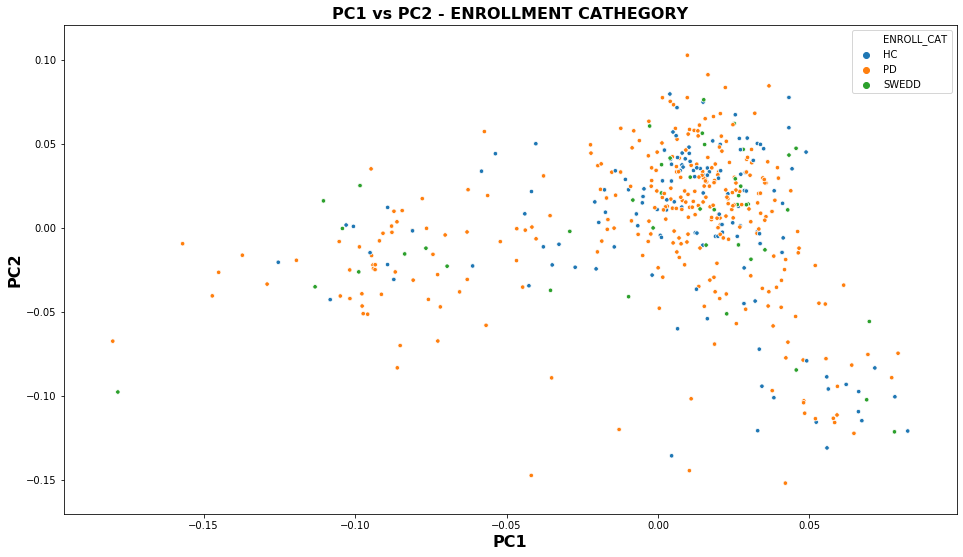

In [91]:
plt.figure(figsize=(16,9))
sns.scatterplot(x='PC1', y='PC2', hue='ENROLL_CAT', data=ppmi_eu_pca, s=20)
plt.title('PC1 vs PC2 - ENROLLMENT CATHEGORY', fontsize=16, fontweight="bold")
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)

Text(0, 0.5, 'PC3')

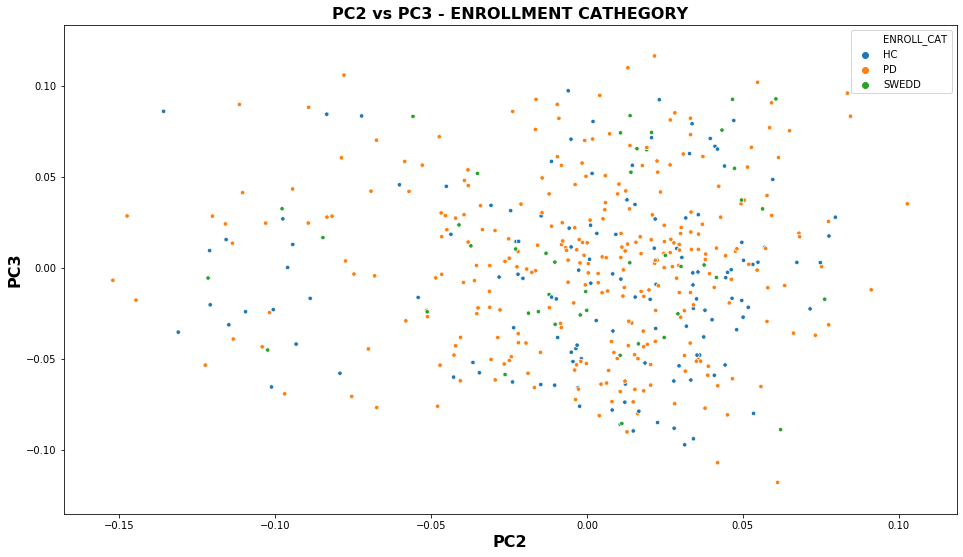

In [92]:
plt.figure(figsize=(16,9))
sns.scatterplot(x='PC2', y='PC3', hue='ENROLL_CAT', data=ppmi_eu_pca, s=20)
plt.title('PC2 vs PC3 - ENROLLMENT CATHEGORY', fontsize=16, fontweight="bold")
plt.xlabel('PC2', fontweight="bold", fontsize=16)
plt.ylabel('PC3', fontweight="bold", fontsize=16)

As expected there is no clear distinction among the three cathegories just observing the genetic makeup of the population.

Before to proceed we need to remove the SWEDD patients, since they are PD patients without dopamine deficiency, which is the main characteristic of parkinsonism. Moreover, this could introduce some bias in our analysis, since their genetic makeup is different from those of HCs and PDs.

In [93]:
ppmi_eu_noswedd_fn = "_".join([ppmi_eu_fn, "noswedd"])
noswedd_fn = "../../data/genotyping/noswedd.txt"
ppmi_eu_pca[ppmi_eu_pca["ENROLL_CAT"] != "SWEDD"].iloc[:, 0:2].to_csv(noswedd_fn, sep=" ", index=False, header=False)

In [94]:
!plink --bfile {ppmi_eu_fn} --keep {noswedd_fn} --make-bed --out {ppmi_eu_noswedd_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_eu_noswedd.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_eu
  --keep ../../data/genotyping/noswedd.txt
  --make-bed
  --out ../../data/genotyping/PPMI_eu_noswedd

32768 MB RAM detected; reserving 16384 MB for main workspace.
129241 variants loaded from .bim file.
469 people (317 males, 152 females) loaded from .fam.
--keep: 425 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 425 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.996663.
129241 variants and 425 people pass filt

After removing SWEDD subjects we remained with 425 individuals. Now let's explore again the population structure by coloring dots by enrollment cathegory

In [95]:
!plink --bfile {ppmi_eu_noswedd_fn} --pca 20 --out {ppmi_eu_noswedd_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_eu_noswedd.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_eu_noswedd
  --out ../../data/genotyping/PPMI_eu_noswedd
  --pca 20

32768 MB RAM detected; reserving 16384 MB for main workspace.
129241 variants loaded from .bim file.
425 people (289 males, 136 females) loaded from .fam.
Using up to 11 threads (change this with --threads).
Before main variant filters, 425 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996663.
129241 variants and 425 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.
--pca: R

In [96]:
status = pd.read_csv(status_fn)

ppmi_eu_noswedd_pca = pd.read_csv(".".join([ppmi_eu_noswedd_fn, "eigenvec"]), sep=" ", header=None)
# assign FID and IID
cnames = ['FID','IID']
for i in range(1, 21):
    cnames.append("PC"+str(i))
ppmi_eu_noswedd_pca.columns = cnames

status = status[status["PATNO"].isin(ppmi_eu_noswedd_pca.iloc[:, 1].tolist())].reset_index(drop=True)
ppmi_eu_noswedd_pca = ppmi_eu_noswedd_pca.merge(status, left_on=["IID"], right_on=["PATNO"])
ppmi_eu_noswedd_pca.head(n=10)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC19,PC20,PATNO,RECRUITMENT_CAT,IMAGING_CAT,ENROLL_DATE,ENROLL_CAT,ENROLL_STATUS,DESCRP_CAT,STATUS_DATE
0,3000,3000,0.023551,0.001279,0.039418,0.064287,-0.001944,-0.034039,0.038249,0.019415,...,-0.052703,0.059449,3000,HC,HC,02/2011,HC,Enrolled,NaN,02/2011
1,3001,3001,0.015950,0.015520,-0.003922,-0.046807,-0.044437,-0.062595,0.035469,-0.035120,...,0.072352,-0.005741,3001,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
2,3002,3002,-0.082312,-0.034941,-0.021605,0.010128,0.027568,0.001679,-0.013329,0.000427,...,0.070677,-0.002857,3002,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
3,3004,3004,0.024220,0.032019,-0.006865,0.000103,-0.048052,-0.047850,0.072379,0.034767,...,0.028038,0.026856,3004,HC,HC,04/2011,HC,Enrolled,NaN,04/2011
4,3006,3006,0.004474,0.059122,0.101468,-0.012026,-0.001775,-0.047204,0.002179,-0.021394,...,0.025742,0.023544,3006,PD,PD,05/2011,PD,Withdrew,NaN,10/2013
5,3008,3008,0.013452,-0.003457,-0.049894,0.050862,-0.045500,0.042441,-0.034965,-0.010748,...,0.063706,-0.100688,3008,HC,HC,06/2011,HC,Enrolled,NaN,06/2011
6,3011,3011,-0.045486,0.024390,0.030287,0.027131,0.029263,-0.001717,-0.005732,-0.000008,...,-0.027354,0.004495,3011,HC,HC,07/2011,HC,Withdrew,NaN,07/2014
7,3012,3012,-0.006209,-0.014760,0.014319,-0.003237,-0.072113,0.060007,-0.022672,0.018019,...,-0.013641,0.020722,3012,PD,PD,11/2011,PD,Enrolled,NaN,11/2011
8,3016,3016,0.039620,0.001440,-0.084329,0.027497,0.045447,0.000142,-0.015530,-0.029433,...,0.023780,-0.054359,3016,HC,HC,02/2012,HC,Enrolled,NaN,02/2012
9,3018,3018,0.016550,0.002319,0.066464,-0.082277,0.057900,0.064888,0.010875,-0.052314,...,0.066151,0.037532,3018,PD,PD,04/2012,PD,Enrolled,NaN,04/2012


Text(0, 0.5, 'PC2')

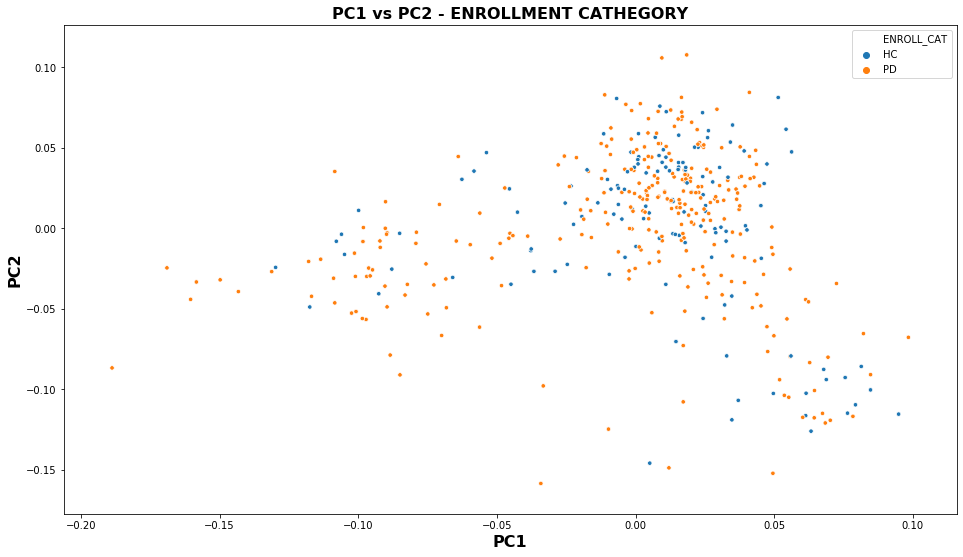

In [97]:
plt.figure(figsize=(16,9))
sns.scatterplot(x='PC1', y='PC2', hue='ENROLL_CAT', data=ppmi_eu_noswedd_pca, s=20)
plt.title('PC1 vs PC2 - ENROLLMENT CATHEGORY', fontsize=16, fontweight="bold")
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)

Text(0, 0.5, 'PC3')

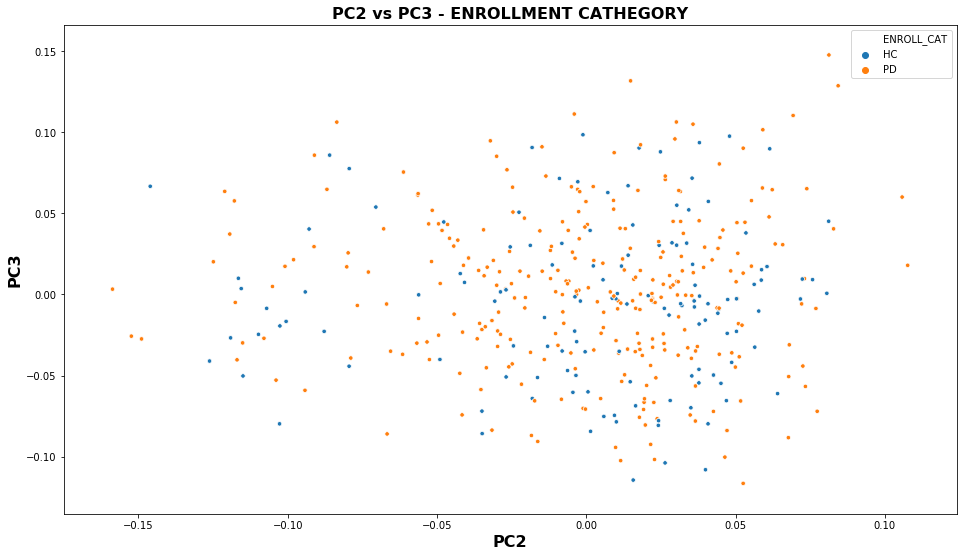

In [98]:
plt.figure(figsize=(16,9))
sns.scatterplot(x='PC2', y='PC3', hue='ENROLL_CAT', data=ppmi_eu_noswedd_pca, s=20)
plt.title('PC2 vs PC3 - ENROLLMENT CATHEGORY', fontsize=16, fontweight="bold")
plt.xlabel('PC2', fontweight="bold", fontsize=16)
plt.ylabel('PC3', fontweight="bold", fontsize=16)

Again as expected the genetic makeup alone is not able to dicriminate among the two considered cathegories (HCs and PDs). Thus, in order to improve our discrimination power we need to add some additional layers of information, like imaging measurements.